In [1]:
setwd("~/ben_lustre/current_projects/kidney_glomTI_response")
suppressPackageStartupMessages(source("https://raw.githubusercontent.com/bjstewart1/helpful_singlecell/main/functions.R"))
ad <- import("anndata")
sc <- import("scanpy")
scv <- import("scvelo")
setwd("~/ben_lustre/current_projects/kidney_glomTI_response/code")
afh = import("anndata_from_h5")
setwd("~/ben_lustre/current_projects/kidney_glomTI_response")
clean_theme <- theme_bw() + theme(axis.text = element_text(color = "black"), axis.title = element_text(color = "black"))

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [2]:
py_config()

python:         /home/jovyan/my-conda-envs/myenv/bin/python
libpython:      /home/jovyan/my-conda-envs/myenv/lib/libpython3.9.so
pythonhome:     /home/jovyan/my-conda-envs/myenv:/home/jovyan/my-conda-envs/myenv
version:        3.9.14 | packaged by conda-forge | (main, Nov 21 2022, 13:18:18)  [GCC 10.4.0]
numpy:          /home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/numpy
numpy_version:  1.22.4

NOTE: Python version was forced by RETICULATE_PYTHON

In [3]:
#read in single cell data ####
sortseq_dir <- "/nfs/team297/bs16/seq_data/sortseq_data"
raw_mat = readRDS(file.path(sortseq_dir, "raw/diagnostics/2022-09-26-CAM-BS.rds"))
features = rownames(raw_mat)

In [4]:
bc_files = grep("BarcodeCounts", list.files(file.path(sortseq_dir, "raw/count_files")), value = T)
bc_mat = lapply(bc_files, function(x){
message(x)
mat_raw = read.csv(file.path(sortseq_dir, "raw/count_files", x), row.names = 1, sep = '\t') 
mat_raw = as.matrix(mat_raw)
colnames(mat_raw) = 1:384
#make a matrix to fill
mat = matrix(0, ncol = 384, nrow = length(features))
colnames(mat) = 1:384
rownames(mat) = features
#fill the matrix
mat[rownames(mat_raw), ] = mat_raw
adata = ad$AnnData(X = as.matrix(t(mat)))
    
#this is the plate
pl = strsplit(x, "_")[[1]][1]
message(pl)
#now sort out the plate coordinates
plate_rows = LETTERS[1:16]
plate_columns = 1:24
plate = read.csv(file.path("./data/sort_data/plate_sorts", paste0(pl, ".csv")), header = FALSE)
rownames(plate) = plate_rows
colnames(plate) = plate_columns
plate_list = list()
p=1
for(row in plate_rows){
    for(col in plate_columns){
        plate_list[[p]] = data.frame("well" = paste0(row, col), "sorted_cell" = plate[row, col], 
                                    "plate" = pl)                          
        p=p+1
    }
}
plate_df = do.call(rbind, plate_list)
adata$obs = cbind(adata$obs, plate_df)
    
#now sort out obs and var names  
adata$obs_names = paste0(adata$obs$plate, "_", adata$obs$well)
adata$var_names = adata$var$Symbol = adata$var$ID = unlist(lapply(strsplit(rownames(mat), "_"), function(x){x[[1]]}))
adata$var_names_make_unique()
    return(adata)
})

CAM-BS-s005_HM7KCBGXM_S1_R2.BarcodeCounts.tsv

CAM-BS-s005

CAM-BS-s006_HM7KCBGXM_S2_R2.BarcodeCounts.tsv

CAM-BS-s006

CAM-BS-s007_HNWL5BGXM_S1_R2.BarcodeCounts.tsv

CAM-BS-s007

CAM-BS-s008_HNNH7BGXM_S1_R2.BarcodeCounts.tsv

CAM-BS-s008

CAM-BS-s009_HM7KCBGXM_S3_R2.BarcodeCounts.tsv

CAM-BS-s009

CAM-BS-s010_HNNH7BGXM_S2_R2.BarcodeCounts.tsv

CAM-BS-s010

CAM-BS-s011_HNNH7BGXM_S3_R2.BarcodeCounts.tsv

CAM-BS-s011

CAM-BS-s012_HNNH7BGXM_S4_R2.BarcodeCounts.tsv

CAM-BS-s012

CAM-BS-s013_HNWL5BGXM_S2_R2.BarcodeCounts.tsv

CAM-BS-s013

CAM-BS-s014_HNWL5BGXM_S3_R2.BarcodeCounts.tsv

CAM-BS-s014

CAM-BS-s015_HNWL5BGXM_S4_R2.BarcodeCounts.tsv

CAM-BS-s015



In [5]:
adata = sc$concat(bc_mat)
adata$var = bc_mat[[1]]$var

In [6]:
adata$obs$IC_status = unlist(lapply(strsplit(adata$obs$sorted_cell, ":"), function(x){x[[2]]}))
adata$obs$kidney = substr(unlist(lapply(strsplit(adata$obs$sorted_cell, ":"), function(x){x[[1]]})), 1, 4) 
compartment = rep("GLOM", nrow(adata$obs))
compartment[grep("TI", unlist(lapply(strsplit(adata$obs$sorted_cell, ":"), function(x){x[[1]]})))] = 'TI'
adata$obs$compartment = compartment
adata$obs$stimulation = "IC"
adata$obs$stimulation[adata$obs$IC_status %in% 'live'] = 'control'

In [7]:
adata$layers = list("counts" = adata$X)

In [8]:
adata$var$MT = 1:nrow(adata$var) %in% grep("^MT-", adata$var$Symbol)
adata$var$ERCC = 1:nrow(adata$var) %in% grep("ERCC", adata$var$Symbol)
adata$var$endogenous = !adata$var$ERCC
sc$pp$calculate_qc_metrics(adata, qc_vars= list("MT", "ERCC", "endogenous"), inplace = TRUE)

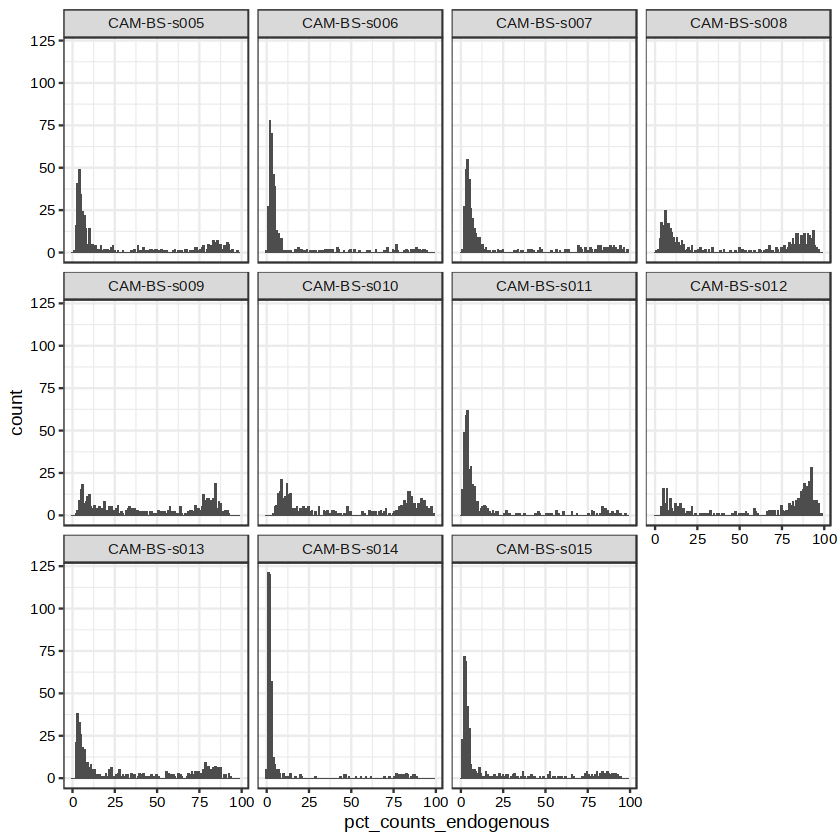

In [9]:
ggplot(adata$obs, aes(x = pct_counts_endogenous)) + geom_histogram(bins = 100, fill = "grey30") + 
 # geom_vline(xintercept = n_genes_cut, color = "red") + 
clean_theme + facet_wrap(~plate)

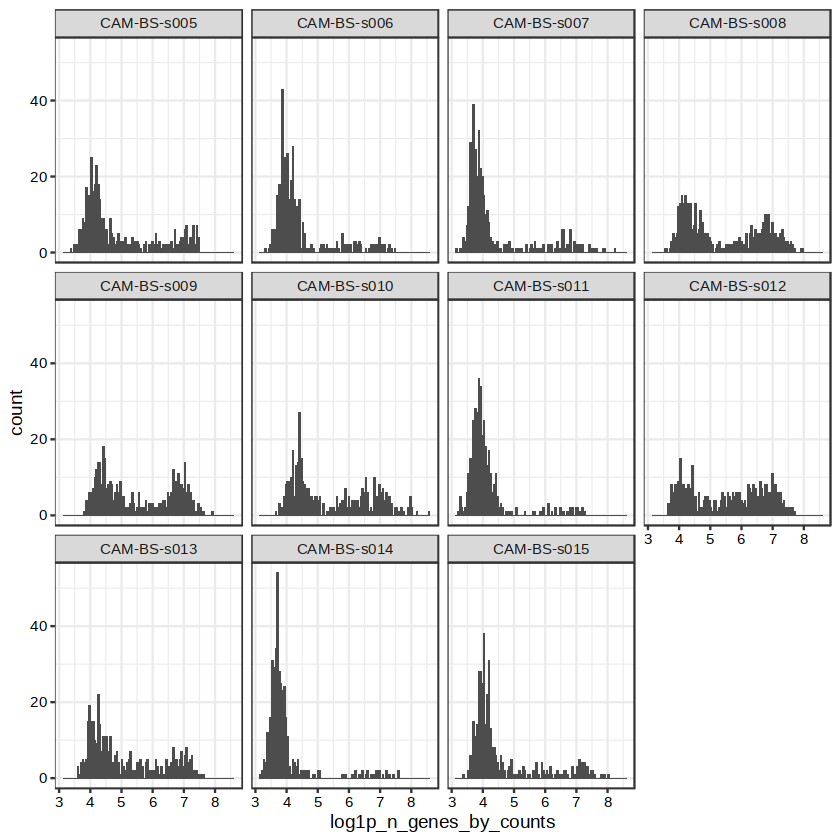

In [10]:
ggplot(adata$obs, aes(x = log1p_n_genes_by_counts)) + geom_histogram(bins = 100, fill = "grey30") + 
 # geom_vline(xintercept = n_genes_cut, color = "red") + 
clean_theme + facet_wrap(~plate)

Loading required package: ggrastr

Loading required package: MASS



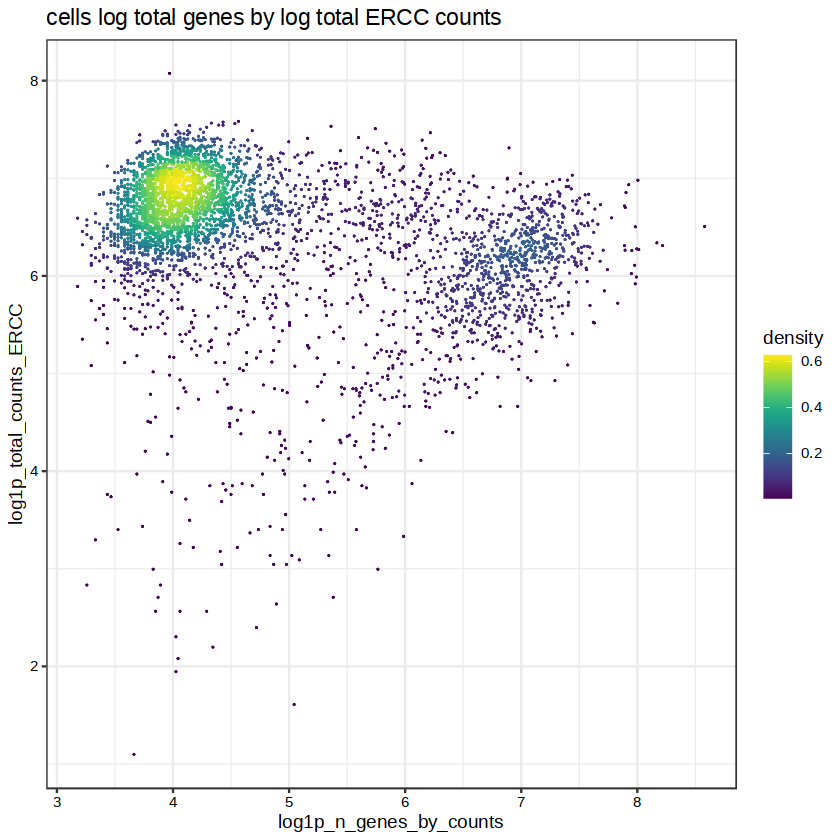

In [11]:
density_plot_raster(x = adata$obs$log1p_n_genes_by_counts, y= adata$obs$log1p_total_counts_ERCC) + 
  clean_theme + xlab("log1p_n_genes_by_counts") + 
  ylab("log1p_total_counts_ERCC") + ggtitle("cells log total genes by log total ERCC counts")

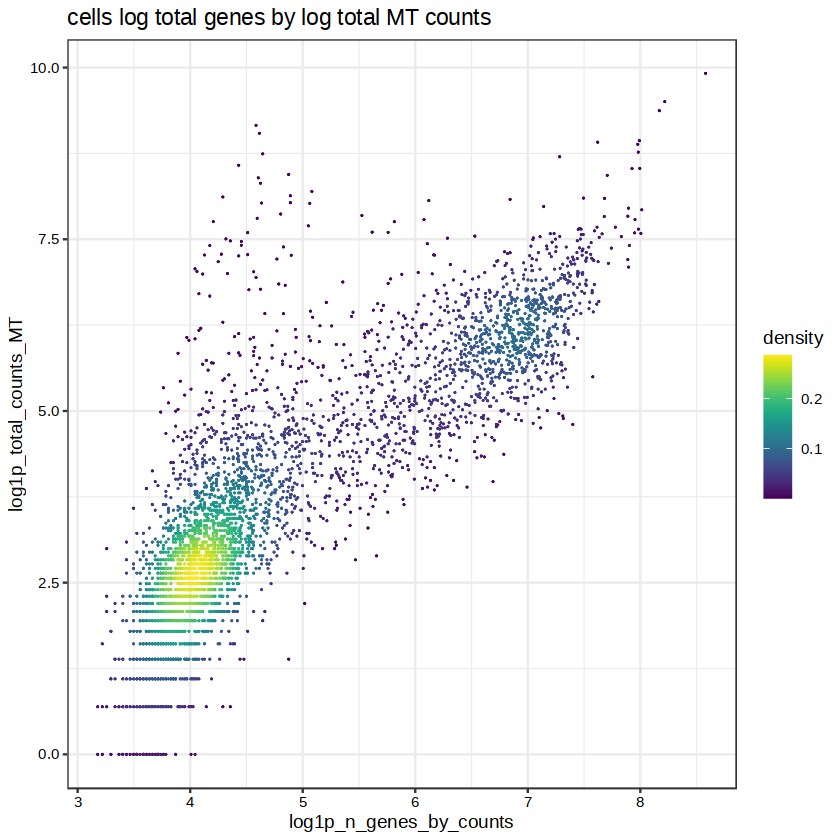

In [12]:
density_plot_raster(x = adata$obs$log1p_n_genes_by_counts, y= adata$obs$log1p_total_counts_MT) + 
  clean_theme + xlab("log1p_n_genes_by_counts") + 
  ylab("log1p_total_counts_MT") + ggtitle("cells log total genes by log total MT counts")

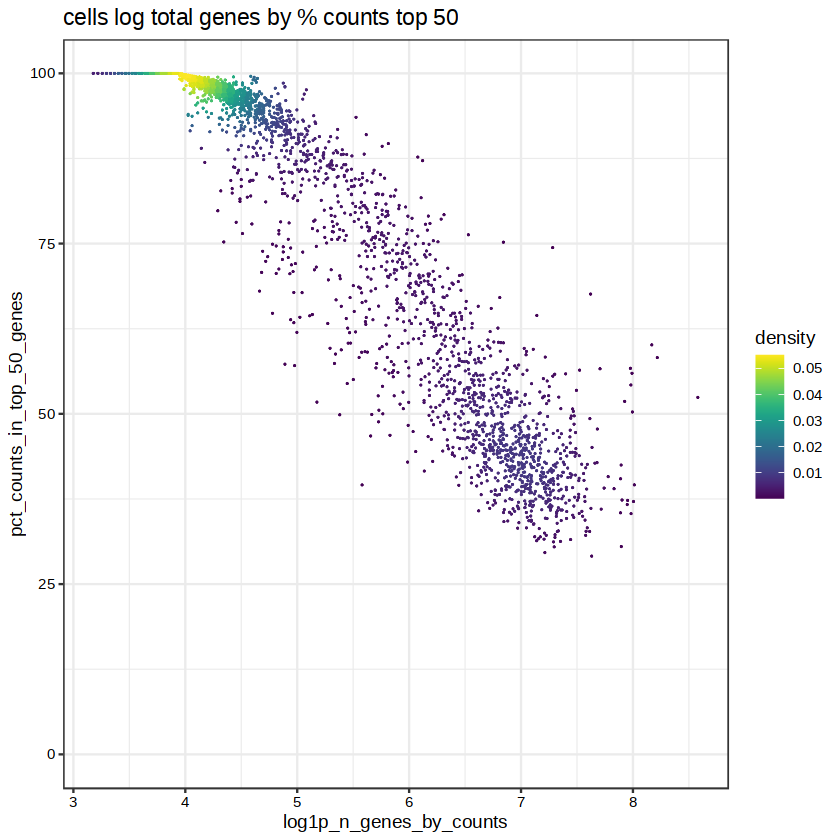

In [13]:
density_plot_raster(x = adata$obs$log1p_n_genes_by_counts, y= adata$obs$pct_counts_in_top_50_genes) + 
  clean_theme + xlab("log1p_n_genes_by_counts") + 
  ylab("pct_counts_in_top_50_genes") +
  ylim(c(0, 100)) + ggtitle("cells log total genes by % counts top 50")

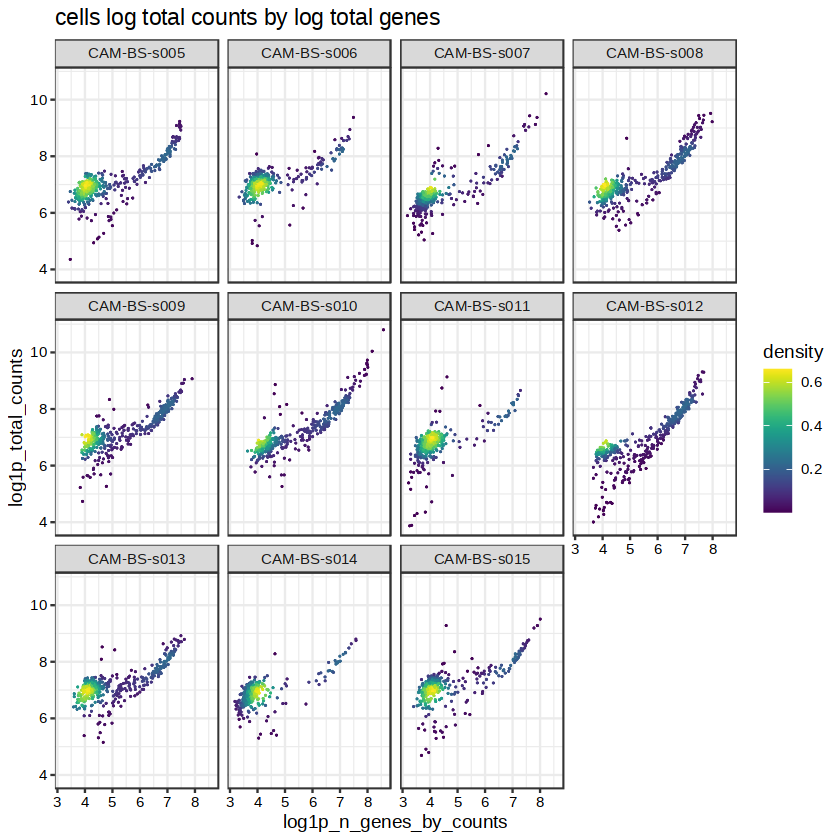

In [14]:
density_plot_raster(x = adata$obs$log1p_n_genes_by_counts, y= adata$obs$log1p_total_counts) + 
  clean_theme + ylab("log1p_total_counts") + 
  xlab("log1p_n_genes_by_counts") + ggtitle("cells log total counts by log total genes") + facet_wrap(~adata$obs$plate)

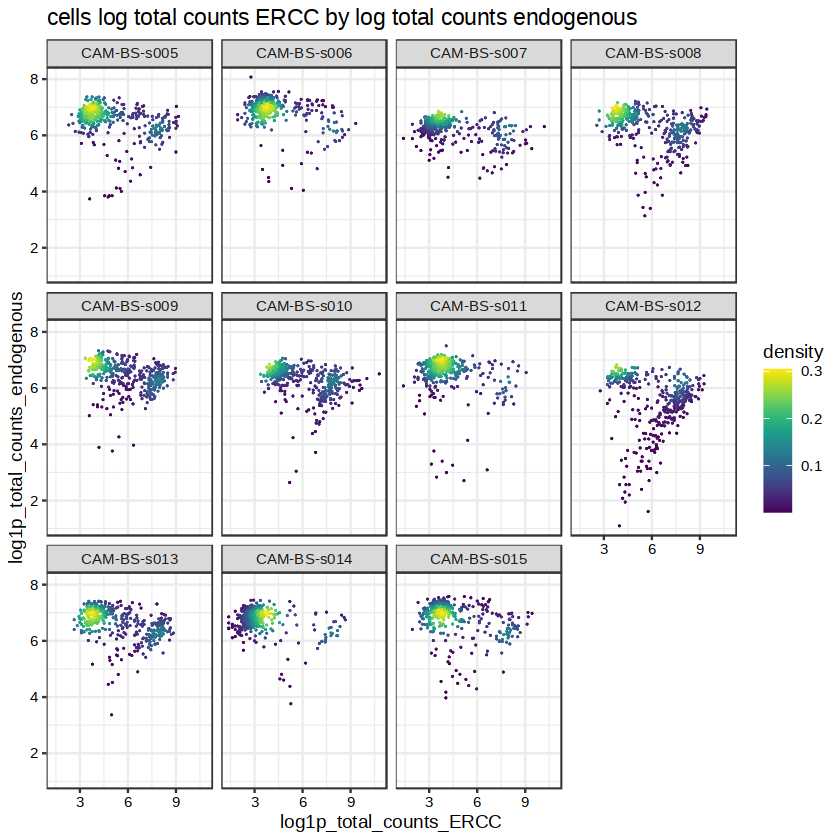

In [15]:
density_plot_raster(x = adata$obs$log1p_total_counts_endogenous, y= adata$obs$log1p_total_counts_ERCC) + 
  clean_theme + facet_wrap(~adata$obs$plate) + ylab("log1p_total_counts_endogenous") + 
  xlab("log1p_total_counts_ERCC") + ggtitle("cells log total counts ERCC by log total counts endogenous") 

In [16]:
pct_counts_endogenous_cutoff = 25
n_genes_by_counts_cutoff = 200

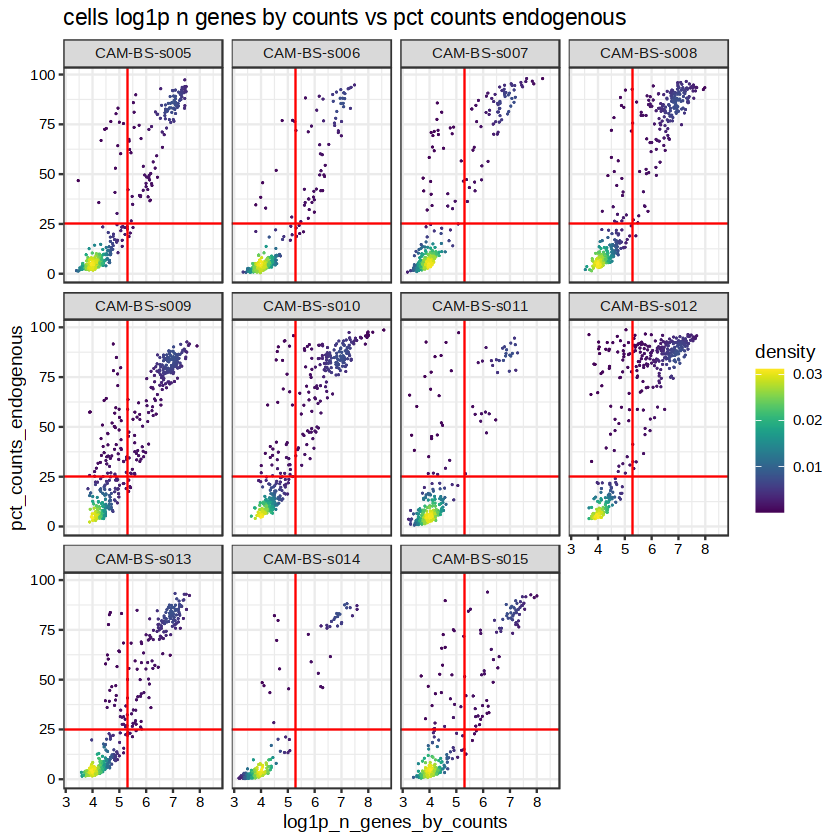

In [17]:
density_plot_raster(x = adata$obs$log1p_n_genes_by_counts, y= adata$obs$pct_counts_endogenous) + 
  clean_theme + facet_wrap(~adata$obs$plate) + ylab("pct_counts_endogenous") + 
  xlab("log1p_n_genes_by_counts") + ggtitle("cells log1p n genes by counts vs pct counts endogenous") + 
geom_vline(aes(xintercept = log1p(n_genes_by_counts_cutoff)), color = 'red') + geom_hline(aes(yintercept = pct_counts_endogenous_cutoff), color = 'red')

In [18]:
adata$obs$cells_keep = adata$obs$pct_counts_endogenous > pct_counts_endogenous_cutoff & adata$obs$n_genes_by_counts > n_genes_by_counts_cutoff

In [19]:
table(adata$obs$cells_keep)


FALSE  TRUE 
 2971  1253 

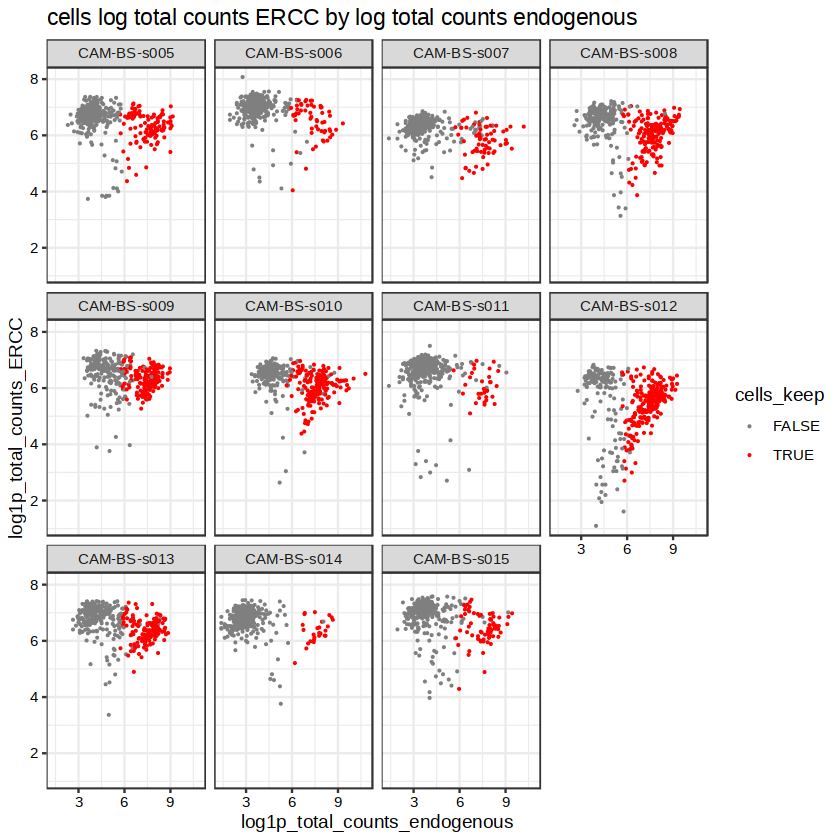

In [20]:
ggplot(adata$obs, aes(x = log1p_total_counts_endogenous, y= log1p_total_counts_ERCC, 
                     color = cells_keep)) + geom_point(pch=19, size = 0.1) + 
scale_color_manual(values = c("TRUE" = 'red', "FALSE" = 'grey50'))   +
  clean_theme + facet_wrap(~adata$obs$plate) + ylab("log1p_total_counts_ERCC") + 
  xlab("log1p_total_counts_endogenous") + ggtitle("cells log total counts ERCC by log total counts endogenous") 

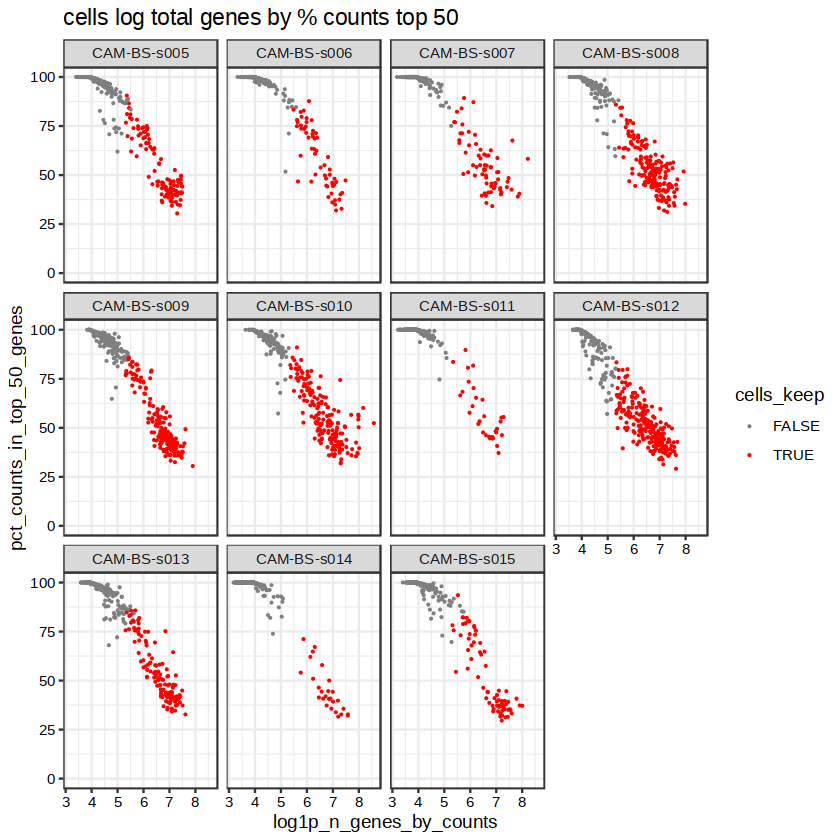

In [21]:
ggplot(adata$obs, aes(x = log1p_n_genes_by_counts, y= pct_counts_in_top_50_genes, 
                     color = cells_keep)) + geom_point(pch=19, size = 0.1) + 
scale_color_manual(values = c("TRUE" = 'red', "FALSE" = 'grey50'))   +
  clean_theme + facet_wrap(~adata$obs$plate)+ xlab("log1p_n_genes_by_counts") + 
  ylab("pct_counts_in_top_50_genes") +
  ylim(c(0, 100)) + ggtitle("cells log total genes by % counts top 50")

In [22]:
adata = adata[adata$obs$cells_keep]

In [23]:
table(adata$obs$compartment, adata$obs$IC_status)

      
       IC- IC+ live
  GLOM 122 442   80
  TI   185 314  110

In [24]:
library(scDblFinder)
adata_dbl = adata$copy()
#preprocess vanilla
message("preprocessing and clustering")
sc$pp$normalize_per_cell(adata_dbl)
sc$pp$log1p(adata_dbl)
sc$pp$filter_genes(adata_dbl, min_cells = ceiling(0.02*adata_dbl$n_obs))
sc$pp$highly_variable_genes(adata_dbl, flavor='seurat_v3', subset = FALSE, n_top_genes = as.integer(2000), layer = 'counts')
sc$pp$pca(adata_dbl)
sc$pp$neighbors(adata_dbl)
#cluster 
sc$tl$leiden(adata_dbl, resolution = 1)
#make sce
#get count matrix
cmat = as(as.matrix(t(adata_dbl$X)), "dgCMatrix") #unfortunately we have to do it this way..
#then make an SCE
sce = SingleCellExperiment::SingleCellExperiment(assays = list('counts' = cmat))
colnames(sce) = adata_dbl$obs_names$values
sce$clusters = adata_dbl$obs$leiden
message("doublet analysis")
set.seed(100)
sce <- scDblFinder(sce, 
                  clusters = 'clusters')
doublet_df = data.frame("dblf_cluster" = colData(sce)$scDblFinder.cluster,
                "dblf_cuts" = colData(sce)$scDblFinder.class,
                "dblf_score" = colData(sce)$scDblFinder.score,
                "dblf_weighted" = colData(sce)$scDblFinder.weighted,
                "dblf_difficulty" = colData(sce)$scDblFinder.difficulty,
                "dblf_cxds_score" = colData(sce)$scDblFinder.cxds_score,
                "dblf_likely_origin" = colData(sce)$scDblFinder.mostLikelyOrigin,
                "dblf_ambiguous_origin" = colData(sce)$scDblFinder.originAmbiguous,
                "dblf_genotype_predicted" = "singlet")

preprocessing and clustering

doublet analysis

11 clusters

Creating ~5000 artificial doublets...

Dimensional reduction

Evaluating kNN...

Training model...

iter=0, 32 cells excluded from training.

iter=1, 5 cells excluded from training.

iter=2, 2 cells excluded from training.

Threshold found:0.764

1 (0.1%) doublets called



In [25]:
adata$obs = cbind(adata$obs, doublet_df)

In [26]:
adata$write_h5ad("data/raw/sort_seq/sort_seq_raw.h5ad")

In [27]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS/LAPACK: /home/jovyan/my-conda-envs/r-4.2/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] scDblFinder_1.12.0          MASS_7.3-60                
 [3] ggrastr_1.0.2               paletteer_1.5.0            
 [5] pbapply_1.7-0               SoupX_1.6.2                
 [7] igraph_1.5.0                DropletUtils_1.18.1        
 [9] pheatmap_1.0.12             cowplot_1.1.1   